In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from views_dataviz.map import mapper, utils
from views_dataviz import color

import sqlalchemy as sa
from ingester3.config import source_db_path

# Mapping examples

This notebook shows how the `Mapper` can be used in your projects. 

We'll first walk through some steps to illustrate the logic. You can also skip to a section that is directly relevant to you:

1. [The basics](#basics)
1. [Adding layers](#layering)
1. [Adding a colorbar](#colorbar)
1. [Plotting categories](#categories)
1. [Adding zoom insets](#insetzoom)
1. [Further customization](#customization)
1. [Mapping presets](#presets)

For illustration, we're getting the country table from db into a GeoDataFrame limited to Africa. We then add mock random predictions and make it as if from month_id 500.

In [2]:
engine = sa.create_engine(source_db_path)
gdf = gpd.GeoDataFrame.from_postgis(
    "SELECT id, geom FROM prod.country WHERE in_africa=1", engine, geom_col='geom'
)
gdf = gdf.to_crs(4326)
np.random.seed(0)
gdf["preds"] = np.random.uniform(low=0, high=1, size=len(gdf))
gdf["month_id"] = 500

Here's an example of how to generate a typical ViEWS map, using a mapping preset.

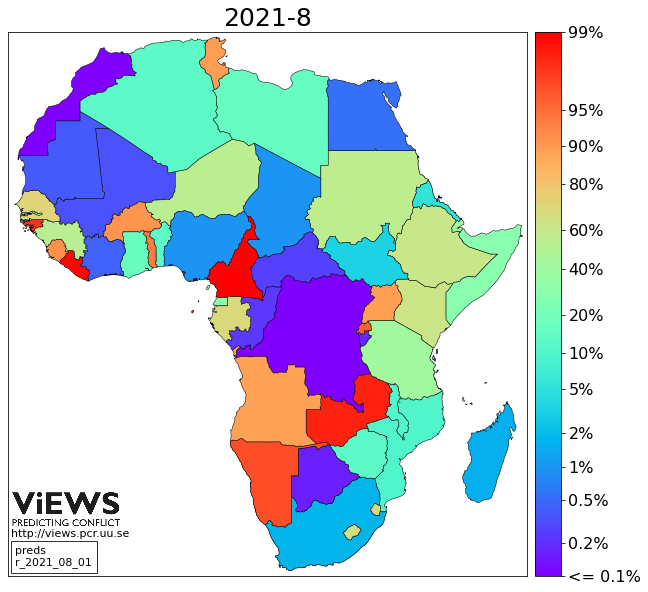

In [3]:
from views_dataviz.map.presets import ViewsAfrica

m = ViewsAfrica(
    label=f"preds\nr_2021_08_01",
    title="2021-8",
    scale="logodds",
).add_layer(
    gdf.loc[gdf.month_id==500],
    edgecolor="black",
    linewidth=0.5,
    column="preds",
)

<a id="basics"></a>
## Basics
___
The `Mapper` class allows you to customize any layer you want, at any point of "layeredness". The following goes through the basics to illustrate this idea.

Initialize a mapper instance with `Mapper`.

In [4]:
?mapper.Mapper

Init signature:
mapper.Mapper(
    width: int,
    height: int,
    bbox: Optional[List[float]] = None,
    cmap: Union[str, matplotlib.colors.Colormap, NoneType] = None,
    frame_on: bool = True,
    title: str = '',
)
Docstring:     
`Map` takes basic properties and allows the user to consecutively add
layers to the Map object. This makes it possible to prepare mapping
"presets" at any level of layeredness that can be built on further.

Attributes
----------
width: Integer value for width in inches.
height: Integer value for height in inches.
bbox: List for the bbox per [xmin, xmax, ymin, ymax].
cmap: String for a matplotlib colormap, or a matplotlib colormap object.
frame_on: Bool for whether to draw a frame around the map.
title: Optional default title at matplotlib's default size.
File:           ~/opt/miniconda3/envs/viewser/lib/python3.9/site-packages/views_dataviz/map/mapper.py
Type:           type
Subclasses:     ViewsAfrica


When you instantiate Mapper without any additional layers in a notebook, it returns an empty frame with a default title. The Mapper instance is set up with some overarching attributes relevant to the figure:

{'width': 10,
 'height': 10,
 'bbox': [-18.5, 52.0, -35.5, 38.0],
 'cmap': None,
 'fig': <Figure size 720x720 with 1 Axes>,
 'ax': <AxesSubplot:title={'center':'example'}>,
 'texts': [],
 'insets': {}}

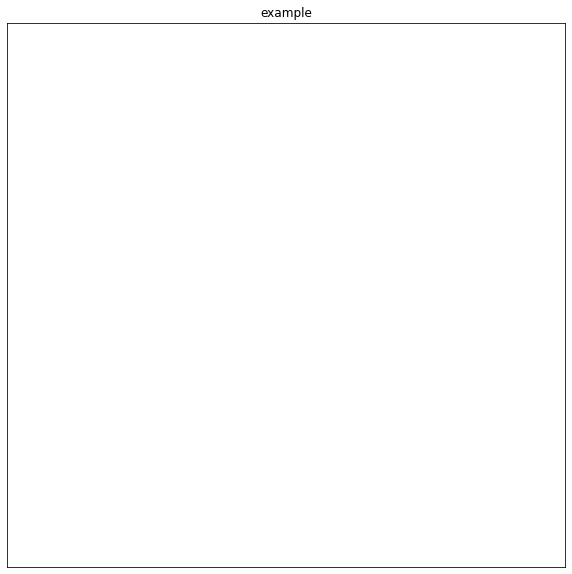

In [5]:
example = mapper.Mapper(
    width=10, 
    height=10,
    bbox=[-18.5, 52.0, -35.5, 38.0],  # xmin, xmax, ymin, ymax for African mainland.
    frame_on=True,
    title="example",
)
example.__dict__

To save your map at any stage, use `save`:

In [6]:
example.save("./empty_example.png")

<a id="layering"></a>
## Adding layers
___

We can now start adding our layers into this frame with the `add_layer` method, which takes a GeoDataFrame, a cmap (either a string, or a matplotlib ColorMap), and any keyword-arguments that can be supplied to the `plot` method on a geopandas GeoDataFrame. You can also supply `inform_colorbar` to set or override a colorbar automatically with information from the layer - this will be illustrated later. Preview the map so far with `.fig`.
> *Note: You can use any GeoDataFrame here. The Mapper does not expect any particular ids, or crs.*

In [7]:
?mapper.Mapper.add_layer

Signature:
mapper.Mapper.add_layer(
    self,
    gdf,
    cmap: Union[str, matplotlib.colors.Colormap, NoneType] = None,
    inform_colorbar: bool = False,
    insets: Optional[List[str]] = None,
    **kwargs,
)
Docstring:
Add a geopandas plot to a new layer.

Parameters
----------
gdf: Geopandas GeoDataFrame to plot.
inform_colorbar: Create or replace the colorbar with the layer data
    if True.
insets: Inset axes to draw layer into.
**kwargs: Geopandas `.plot` keyword arguments.
File:      ~/opt/miniconda3/envs/viewser/lib/python3.9/site-packages/views_dataviz/map/mapper.py
Type:      function


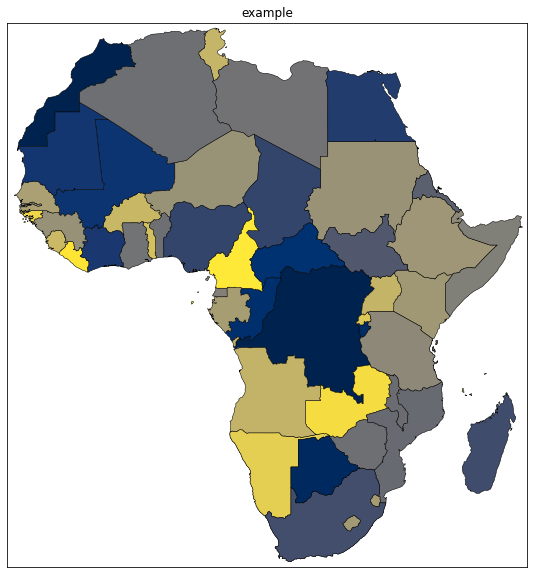

<Figure size 432x288 with 0 Axes>

In [8]:
example = example.add_layer(
    gdf=gdf.loc[gdf.month_id==500],
    cmap="cividis",
    edgecolor="black",
    linewidth=0.5,
    column="preds",
)
example.fig

Stack layers simply with additional `add_layer` calls, for instance when you want to add a marker. Use `zorder` if you need the adjust the order of the layers at any point.

/var/folders/c7/6mryyyp575z11p41y6_fflfw0000gn/T/ipykernel_88507/4157769581.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf=gdf.loc[(gdf.month_id==500) & (gdf.preds > .8)].geometry.centroid,


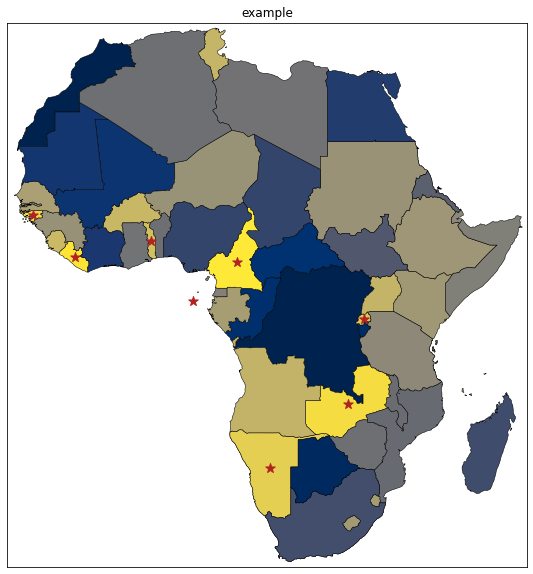

<Figure size 432x288 with 0 Axes>

In [9]:
example = example.add_layer(
    gdf=gdf.loc[(gdf.month_id==500) & (gdf.preds > .8)].geometry.centroid,
    marker="*",
    markersize=100,
    color="firebrick"
)
example.fig

<a id="colorbar"></a>
## Adding a colorbar
___

With respect to the colorbar, you have various options. One is to use the `legend` parameter when adding a layer. This however sets up a colorbar that is not equal in height to the figure frame:

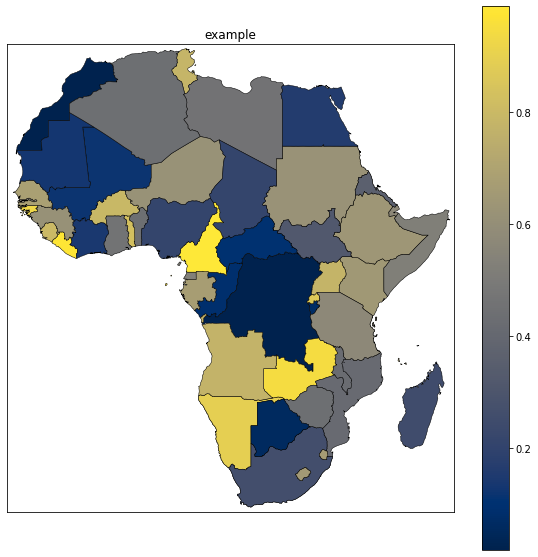

In [10]:
mapper.Mapper(
    width=10, 
    height=10,
    bbox=[-18.5, 52.0, -35.5, 38.0],  # xmin, xmax, ymin, ymax for African mainland.
    frame_on=True,
    title="example",
).add_layer(
    gdf=gdf.loc[gdf.month_id==500],
    cmap="cividis",
    edgecolor="black",
    linewidth=0.5,
    column="preds",
    legend=True
)

GeoPandas's suggested solution is to add a custom ax instead, and add a colorbar to that. The `add_colorbar` method allows you to do so. Note that in this case you have to provide the cmap, vmin, and vmax. 

In [11]:
?mapper.Mapper.add_colorbar

Signature:
mapper.Mapper.add_colorbar(
    self,
    cmap,
    vmin,
    vmax,
    location='right',
    size='5%',
    pad=0.1,
    alpha=1,
    labelsize=16,
    tickparams=None,
)
Docstring:
Add custom colorbar to Map.

Needed since GeoPandas legend and plot axes do not align, see:
https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html

Parameters
----------
cmap: Matplotlib colormap object or string reference (e.g. "viridis").
vmin: Minimum value of range colorbar.
vmax: Maximum value of range colorbar.
location: String for location of colorbar: "top", "bottom", "left"
    or "right".
size: Size in either string percentage or number of pixels.
pad: Float for padding between the plot's frame and colorbar.
alpha: Float for alpha to apply to colorbar.
labelsize: Integer value for the text size of the ticklabels.
tickparams: Dictionary containing value-label pairs. For example:
    {0.05: "5%", 0.1: "10%"}
File:      ~/opt/miniconda3/envs/viewser/lib/python3.9/site-pac

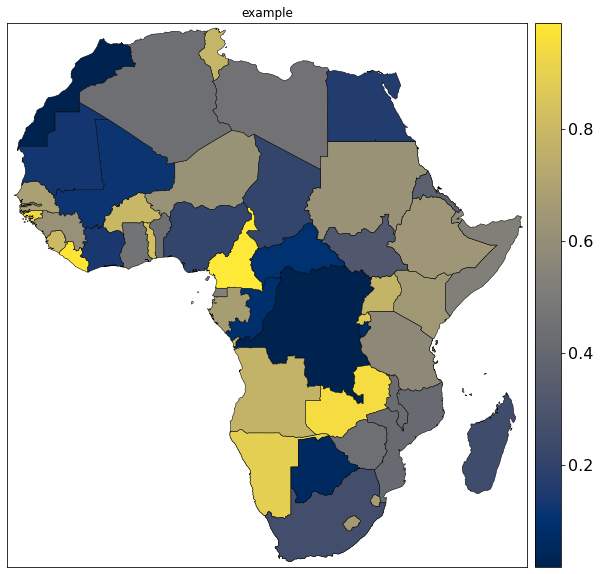

In [12]:
mapper.Mapper(
    width=10, 
    height=10,
    bbox=[-18.5, 52.0, -35.5, 38.0],  # xmin, xmax, ymin, ymax for African mainland.
    frame_on=True,
    title="example",
).add_layer(
    gdf=gdf.loc[gdf.month_id==500],
    cmap="cividis",
    edgecolor="black",
    linewidth=0.5,
    column="preds",
).add_colorbar(
    cmap="cividis", 
    vmin=gdf.loc[gdf.month_id==500, "preds"].min(),
    vmax=gdf.loc[gdf.month_id==500, "preds"].max(),
)

The `add_colorbar` method gives you full control over the colorbar. Alternatively, you can simply set a default colorbar to the min-max range of the series plotted with the `inform_colorbar` argument of the `add_layer` method:

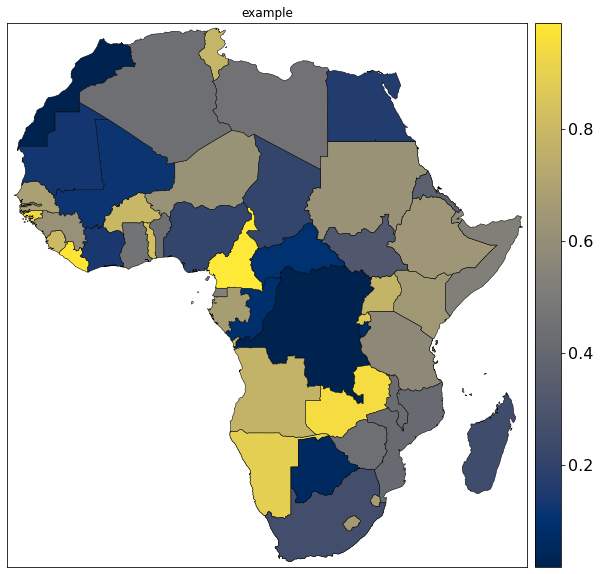

In [13]:
example = mapper.Mapper(
    width=10, 
    height=10,
    bbox=[-18.5, 52.0, -35.5, 38.0],  # xmin, xmax, ymin, ymax for African mainland.
    frame_on=True,
    title="example",
).add_layer(
    gdf=gdf.loc[gdf.month_id==500],
    cmap="cividis",
    edgecolor="black",
    linewidth=0.5,
    column="preds",
    inform_colorbar=True,
)

<a id="categories"></a>
## Plotting categories
___

A continuous colorbar of course does not always apply. When your data is of a categorical or ordinal nature, you can instead simply use the in-built categorical legend by setting `categorical=True` and `legend=True`. Any modifications of the legend can be supplied as a dictionary to `legend_kwds`:

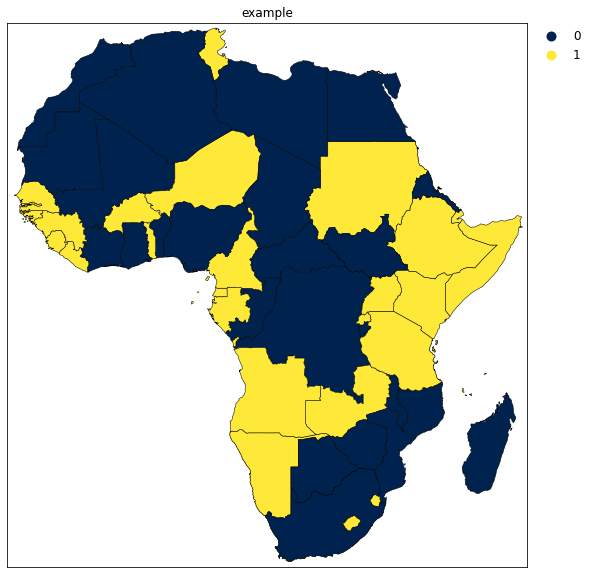

In [14]:
gdf["categories"] = np.where(gdf.preds > 0.5, 1, 0) 

categorical = mapper.Mapper(
    width=10, 
    height=10,
    bbox=[-18.5, 52.0, -35.5, 38.0],
    frame_on=True,
    title="example",
).add_layer(
    gdf=gdf.loc[gdf.month_id==500],
    cmap="cividis",
    edgecolor="black",
    linewidth=0.5,
    column="categories",
    categorical=True,
    legend=True,
    legend_kwds={
        'loc': 'upper left',
        'bbox_to_anchor': (1.01, 1),
        "borderaxespad": 0.2,
        "frameon": False,
        "fontsize": 12
    }
)

You can replace the legend labels using the `replace_legend_labels` method:

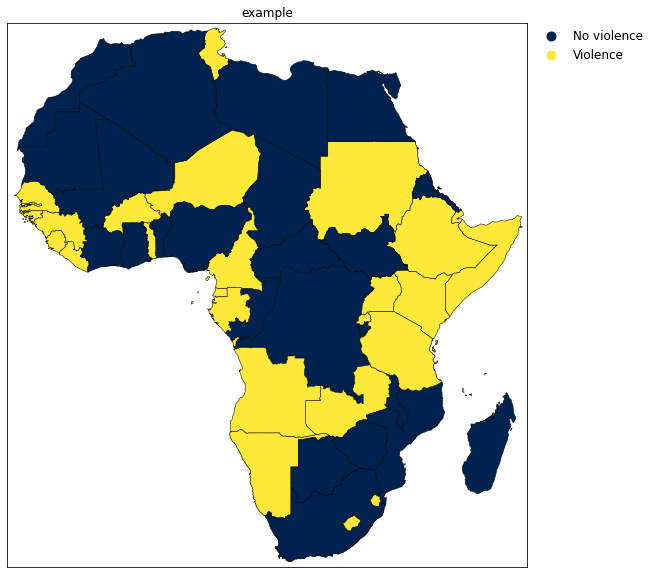

In [15]:
categorical.replace_legend_labels({"0": "No violence", "1": "Violence"})
categorical.fig

<a id="insetzoom"></a>
## Adding zoom insets
___

In [16]:
?mapper.Mapper.add_zoom_inset

Signature:
mapper.Mapper.add_zoom_inset(
    self,
    name: str,
    bbox: List[float],
    zoom: int = 4,
    loc: Literal[1, 2, 3, 4] = 3,
    corner_loc1: Literal[1, 2, 3, 4] = 2,
    corner_loc2: Literal[1, 2, 3, 4] = 3,
    xy_inset: float = (1.02, 0.35),
)
Docstring:
Add a zoom inset to the map figure.

Parameters
----------
name: Identifier to give to the particular inset.
bbox: Bounding box to zoom in on per [xmin, xmax, ymin, ymax].
zoom: Scaling factor of the data axes. zoom > 1 will enlargen the
    coordinates (i.e., "zoomed in"), while zoom < 1 will shrink the
    coordinates (i.e., "zoomed out").
loc: One of four: upper right (1), upper left (2), lower left (3), or
    lower right (4)
corner_loc1: Corner location of the first connecting line: upper right
    (1), upper left (2), lower left (3), or lower right (4).
corner_loc2: Corner location of the second connecting line: upper right
    (1), upper left (2), lower left (3), or lower right (4).
xy_inset: Location of x an

You can add any number of insets to your plot with the `add_zoom_inset` method. Notice that you set these **before** adding your layers, and then refer to them by name with the `insets` parameter of the `add_layer` method. This means you can specifically select which layers you want to include in the zoom insets.

/var/folders/c7/6mryyyp575z11p41y6_fflfw0000gn/T/ipykernel_88507/1730155945.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf=gdf.loc[(gdf.month_id==500) & (gdf.preds > .8)].geometry.centroid,


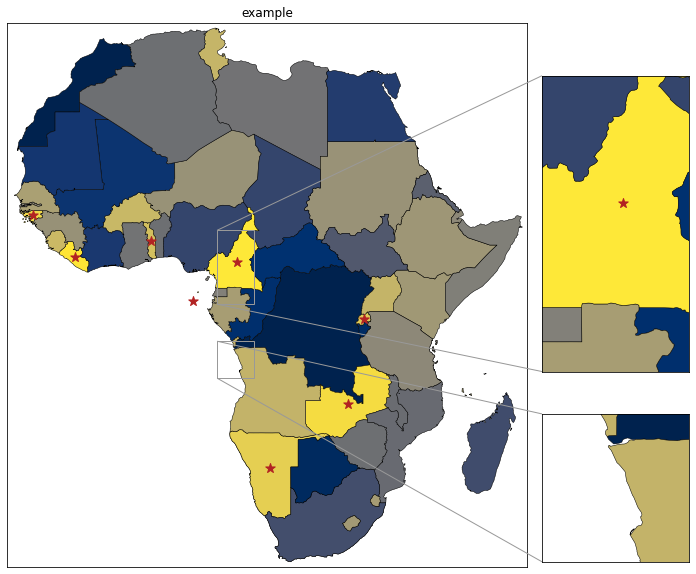

In [17]:
mapper.Mapper(
    width=10, 
    height=10,
    bbox=[-18.5, 52.0, -35.5, 38.0],  # xmin, xmax, ymin, ymax for African mainland.
    frame_on=True,
    title="example",
).add_zoom_inset(
    name="test",
    bbox=[10, 15, 0, 10], 
    zoom=4,
    corner_loc1=2,
    corner_loc2=3
).add_zoom_inset(
    name="test2",
    bbox=[10, 15, -10, -5], 
    zoom=4,
    loc=3,
    corner_loc1=2,
    corner_loc2=3,
    xy_inset=(1.02, 0)
).add_layer(
    gdf=gdf.loc[gdf.month_id==500],
    cmap="cividis",
    edgecolor="black",
    linewidth=0.5,
    column="preds",
    legend=False,
    insets=["test", "test2"]
).add_layer(
    gdf=gdf.loc[(gdf.month_id==500) & (gdf.preds > .8)].geometry.centroid,
    marker="*",
    markersize=100,
    color="firebrick",
    insets=["test"]
)

<a id="customization"></a>
## Further customization
___

### Ax

Note that you can retrieve the ax from your instance at any stage, and perform operations on and with that as usual in matplotlib. For instance:

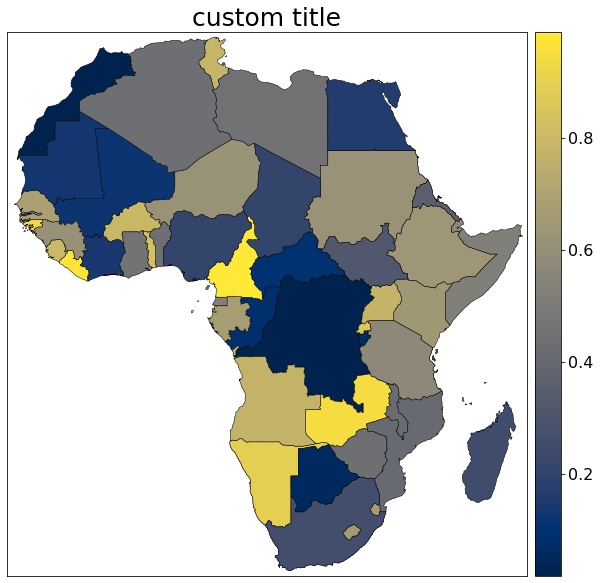

In [18]:
ax = example.ax
ax.set_title("custom title", size=25)
example.fig

### Colorbar

While `add_colorbar` gives control over the colorbar's customization, you may want to make changes after it's already set. You do this manually using the `cax` and `cbar` attributes, for instance:

In [19]:
example.cbar.set_ticks([.3, .6, .9])
example.cbar.set_ticklabels(["3 USD", "6 USD", "9 USD"])

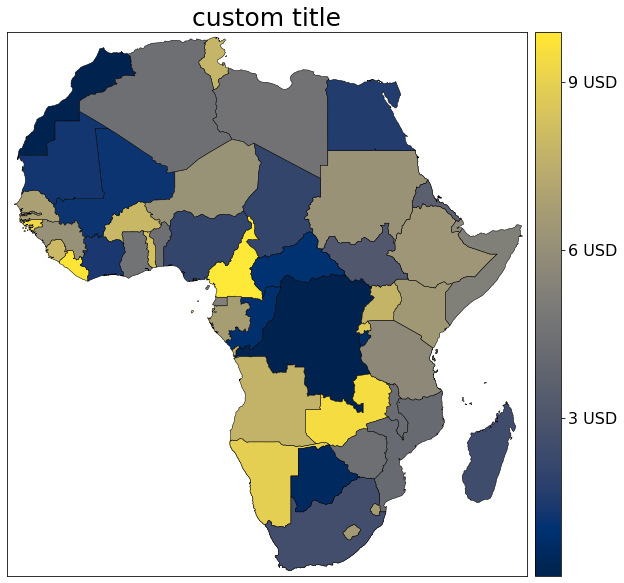

In [20]:
example.fig

### Adding a custom title

`add_title` allows you to set a custom title directly onto the instance, which overrides the default.

In [21]:
?mapper.Mapper.add_title

Signature: mapper.Mapper.add_title(self, title: str, **kwargs)
Docstring:
Add a custom title. Replaces default.

Parameters
----------
title: String title.
**kwargs: Matplotlib `ax.set_title` keyword arguments.
File:      ~/opt/miniconda3/envs/viewser/lib/python3.9/site-packages/views_dataviz/map/mapper.py
Type:      function


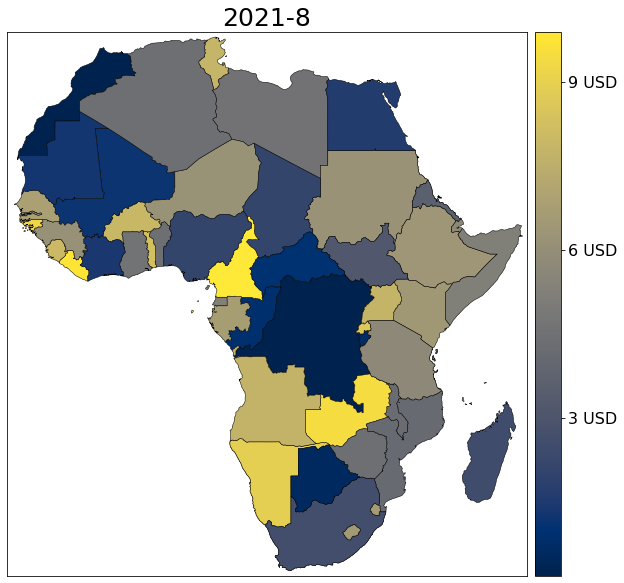

In [22]:
example = example.add_title(title="2021-8", size=25)
example.fig

### Adding a "ViEWS textbox"

In [23]:
?mapper.Mapper.add_views_textbox

Signature: mapper.Mapper.add_views_textbox(self, text: str, textsize: int = 15)
Docstring:
Add ViEWS textbox to figure. Logo and url are hardcoded.

        Parameters
        ----------
        text: String text. Note that newlines can be used, for example:
            "Model A
r_2021_12_01"
        textsize: Integer for textsize.
        
File:      ~/opt/miniconda3/envs/viewser/lib/python3.9/site-packages/views_dataviz/map/mapper.py
Type:      function


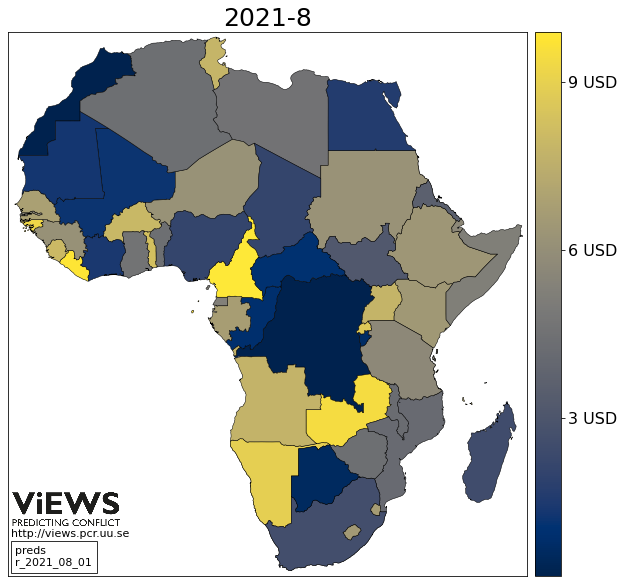

In [24]:
example = example.add_views_textbox(
    text="preds\nr_2021_08_01", 
    textsize=16
)
example.fig

### Basemaps

Add a basemap with `add_basemap`. This uses contextily, for details please see: https://contextily.readthedocs.io/en/latest/, with default source set to `ctx.providers.CartoDB.Voyager`.

In [25]:
?mapper.Mapper.add_basemap

Signature:
mapper.Mapper.add_basemap(
    self,
    crs: int = 4326,
    source={'url': 'https://{s}.basemaps.cartocdn.com/{variant}/{z}/{x}/{y}{r}.png', 'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>', 'attribution': '(C) OpenStreetMap contributors (C) CARTO', 'subdomains': 'abcd', 'max_zoom': 20, 'variant': 'rastertiles/voyager', 'name': 'CartoDB.Voyager'},
    **kwargs,
)
Docstring:
Add a basemap to Map.

Parameters
----------
crs: Integer value for EPSG coordinate system used.
source: Contextily tile to apply.
**kwargs: `ctx.add_basemap` keyword arguments.
File:      ~/opt/miniconda3/envs/viewser/lib/python3.9/site-packages/views_dataviz/map/mapper.py
Type:      function


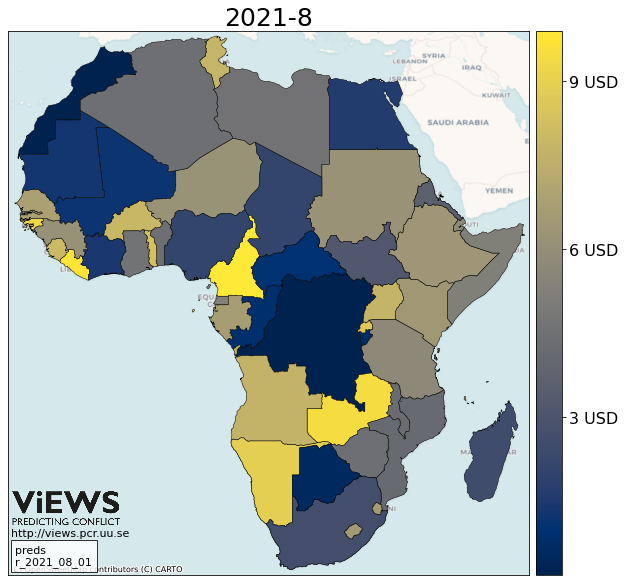

<Figure size 432x288 with 0 Axes>

In [26]:
example = example.add_basemap()
example.fig

<a id="presets"></a>
## Mapping presets
___

You can make mapping presets by inheriting from the `Mapper` class. Presets make it easy to share pre-defined looks between projects.

Presets are currently collected in `views_dataviz/map/presets/views.py`, and can be imported as in the example at the top of this notebook. See for instance the standard preset used for ViEWS maps focused on Africa:

In [27]:
from views_dataviz.map.presets import ViewsAfrica
?ViewsAfrica

Init signature:
ViewsAfrica(
    width=10,
    height=10,
    bbox=[-18.5, 52.0, -35.5, 38.0],
    cmap='viridis',
    frame_on=True,
    title='',
    label='',
    scale=None,
    vmin=None,
    vmax=None,
    tickparams=None,
)
Docstring:     
Inherits from Mapper. Runs methods on init that build the ViEWS defaults.

Attributes
----------
title: Add a custom str title.
label: Custom str label to add to textbox.
scale: Scale to set map to. Either "logodds", "prob", "delta", or None.
vmin: Minimum value of scale.
vmax: Maximum value of scale.
tickparams: Dictionary of custom tick parameters, by key-value pairs. For
    example: {0.05: "5%", 0.1: "10%"}.
File:           ~/opt/miniconda3/envs/viewser/lib/python3.9/site-packages/views_dataviz/map/presets/views.py
Type:           type
Subclasses:     
